In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%cd drive/My\ Drive/capstone_2

/content/drive/My Drive/capstone_2


# Data Import

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
train = pd.read_csv('train.csv', parse_dates=['timestamp'])
train.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
building_id      20216100 non-null int64
meter            20216100 non-null int64
timestamp        20216100 non-null datetime64[ns]
meter_reading    20216100 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 616.9 MB


In [5]:
building = pd.read_csv('building_metadata.csv')
building.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
site_id        1449 non-null int64
building_id    1449 non-null int64
primary_use    1449 non-null object
square_feet    1449 non-null int64
year_built     675 non-null float64
floor_count    355 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 68.0+ KB


There are `null` values in `year_built` and `floor_count` of building_metadata.csv.

In [6]:
weather_train = pd.read_csv('weather_train.csv', parse_dates=['timestamp'])
weather_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
site_id               139773 non-null int64
timestamp             139773 non-null datetime64[ns]
air_temperature       139718 non-null float64
cloud_coverage        70600 non-null float64
dew_temperature       139660 non-null float64
precip_depth_1_hr     89484 non-null float64
sea_level_pressure    129155 non-null float64
wind_direction        133505 non-null float64
wind_speed            139469 non-null float64
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 9.6 MB


There are `null` values in weather_train.csv. A proper method need to be generate to handle the missing values in time series.

In [7]:
train.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01,0.0
1,1,0,2016-01-01,0.0
2,2,0,2016-01-01,0.0
3,3,0,2016-01-01,0.0
4,4,0,2016-01-01,0.0


In [8]:
train.tail()

,building_id,meter,timestamp,meter_reading
20216095,1444,0,2016-12-31 23:00:00,8.750
20216096,1445,0,2016-12-31 23:00:00,4.825
20216097,1446,0,2016-12-31 23:00:00,0.000
20216098,1447,0,2016-12-31 23:00:00,159.575
20216099,1448,0,2016-12-31 23:00:00,2.850


Target values `meter_reading` are collected for each building hourly for the entire year of 2016. Some are 0 though.

In [9]:
building.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [10]:
building.tail()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
1444,15,1444,Entertainment/public assembly,19619,1914.0,NaN
1445,15,1445,Education,4298,NaN,NaN
1446,15,1446,Entertainment/public assembly,11265,1997.0,NaN
1447,15,1447,Lodging/residential,29775,2001.0,NaN
1448,15,1448,Office,92271,2001.0,NaN


In [11]:
weather_train.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


In [12]:
weather_train.tail()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
139768,15,2016-12-31 19:00:00,3.0,NaN,-8.0,NaN,NaN,180.0,5.7
139769,15,2016-12-31 20:00:00,2.8,2.0,-8.9,NaN,1007.4,180.0,7.7
139770,15,2016-12-31 21:00:00,2.8,NaN,-7.2,NaN,1007.5,180.0,5.1
139771,15,2016-12-31 22:00:00,2.2,NaN,-6.7,NaN,1008.0,170.0,4.6
139772,15,2016-12-31 23:00:00,1.7,NaN,-5.6,-1.0,1008.5,180.0,8.8


In [13]:
# Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df
train = reduce_mem_usage(train)
building = reduce_mem_usage(building)
weather = reduce_mem_usage(weather_train)

Mem. usage decreased to 289.19 Mb (53.1% reduction)
Mem. usage decreased to  0.03 Mb (60.3% reduction)
Mem. usage decreased to  3.07 Mb (68.1% reduction)


ref https://www.kaggle.com/caesarlupum/ashrae-start-here-a-gentle-introduction

# Exploratory Data Analysis
## Some plots

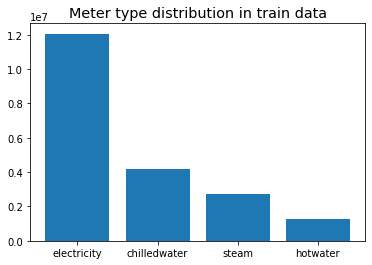

In [14]:
_ = train.meter.value_counts()
plt.bar(_.index, _.values)
plt.style.use('ggplot')
plt.xticks([0,1,2,3], ['electricity', 'chilledwater', 'steam', 'hotwater'])
plt.title('Meter type distribution in train data')
plt.show()

Most data in train.csv are collected from electricity meter, and hotwater meter is the least frequent.

In [0]:
train_df = train.set_index(['timestamp'])

/usr/local/lib/python3.6/dist-packages/pandas/util/_decorators.py:208: FutureWarning: Passing datetime64-dtype data to TimedeltaIndex is deprecated, will raise a TypeError in a future version
  return func(*args, **kwargs)


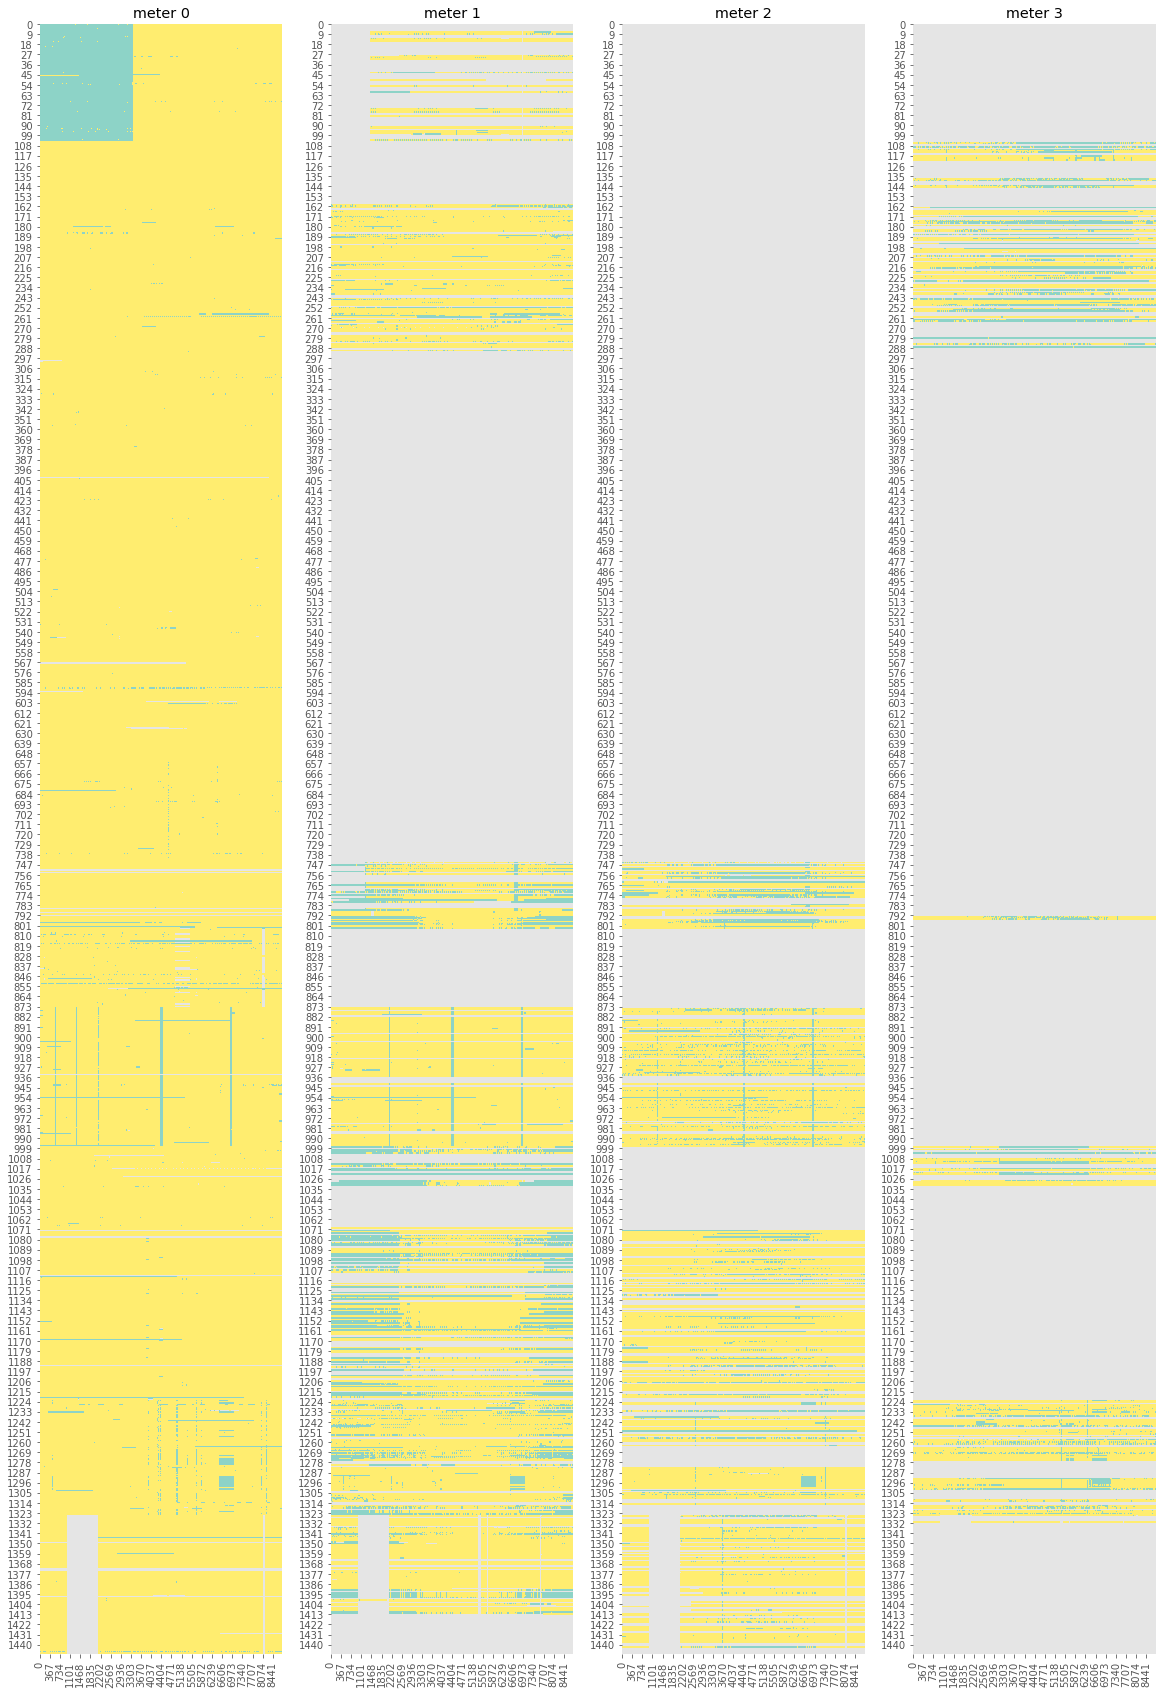

In [16]:
f,a=plt.subplots(1,4,figsize=(20,30))
for meter in np.arange(4):
    df = train_df[train_df.meter==meter].copy().reset_index()
    df['timestamp'] = pd.to_timedelta(df.timestamp).dt.total_seconds() / 3600
    df['timestamp'] = df.timestamp.astype(int)
    df.timestamp -= df.timestamp.min()
    missmap = np.empty((1449, df.timestamp.max()+1))
    missmap.fill(np.nan)
    for l in df.values:
        if l[2]!=meter:continue
        missmap[int(l[1]), int(l[0])] = 0 if l[3]==0 else 1
    a[meter].set_title(f'meter {meter:d}')
    sns.heatmap(missmap, cmap='Set3', ax=a[meter], cbar=False)


*   X axis: hours elapsed since 2016-01-01
*   Y axis: building_id
*   Yellow: meter reading is non-zero value
*   Green: meter reading is 0
*   Gray: meter reading is not available

Green lines mean that for sometime the meter in some specific building has been read as 0, and gray lines mean that the meter reading is not available, which could be due to that a certain type of meter is not available in the building, or that the reading is not recorded in dataset for certain time in certain building.





`



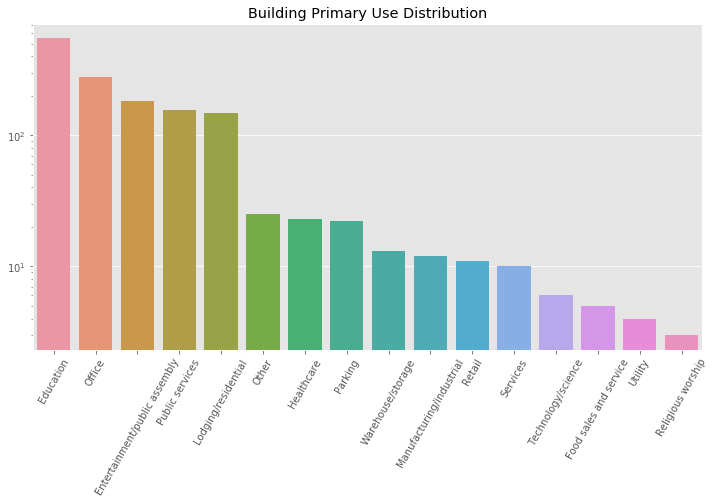

In [17]:
_ = building.primary_use.value_counts()
plt.figure(figsize=(12, 6))
sns.barplot(_.index, _.values, log=True)
plt.xticks(rotation=60)
plt.title('Building Primary Use Distribution')
plt.show()

Among the buildings in building_metadata.csv, the most common ones are used for education and office, and the least common ones are for religius worship and utility. 

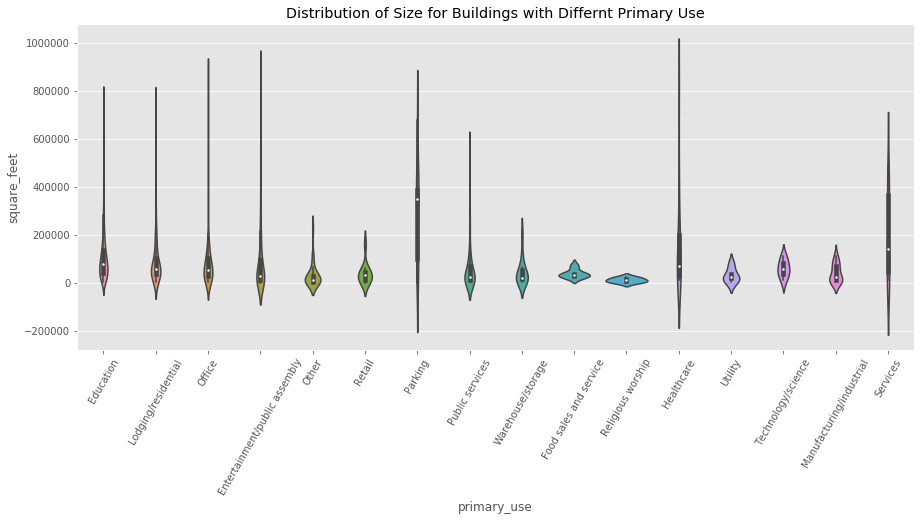

In [18]:
plt.figure(figsize=(15, 6))
sns.violinplot(building.primary_use, building.square_feet)
plt.xticks(rotation=60)
plt.title('Distribution of Size for Buildings with Differnt Primary Use')
plt.show()

Buildings for retail, food sales and service, religious worship, utility, technology/science, manufactring/industrial, warehouse/storage and other have relatively small span of size distribution. Buildings for the rest of uses differ very much in size.

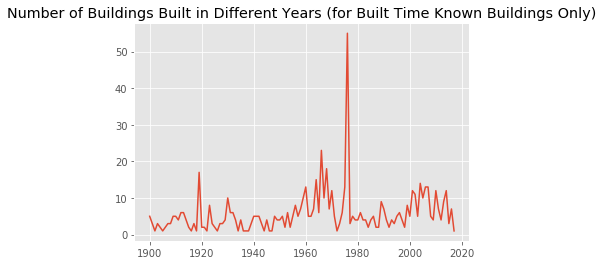

In [19]:
_ = building.year_built.value_counts().sort_index()
plt.plot(_.index, _.values)
plt.title('Number of Buildings Built in Different Years (for Built Time Known \
Buildings Only)')
plt.show()

A large of buildings from building_metadata.csv (if their built years are known) were build in 1960-1980, meaning they were 36-56 years old when energy data were collected. 

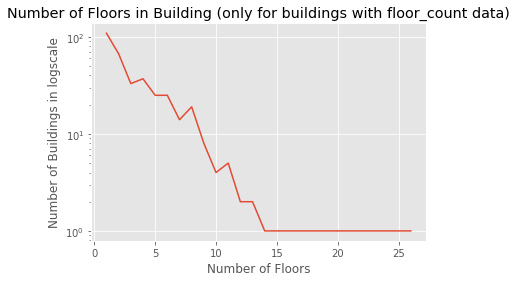

In [20]:
_ = building.floor_count.value_counts().sort_index()
plt.plot(_.index, _.values)
plt.xlabel('Number of Floors')
plt.ylabel('Number of Buildings in logscale')
plt.yscale('log')
plt.title('Number of Floors in Building (only for buildings with floor_count data)')
plt.show()

Most buildings in building_metadata.csv have less then 10 floors, if their floor counts are known in the dataset.

In [21]:
weather.site_id.nunique()

16

There are 16 different sites in weather_train.csv.

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


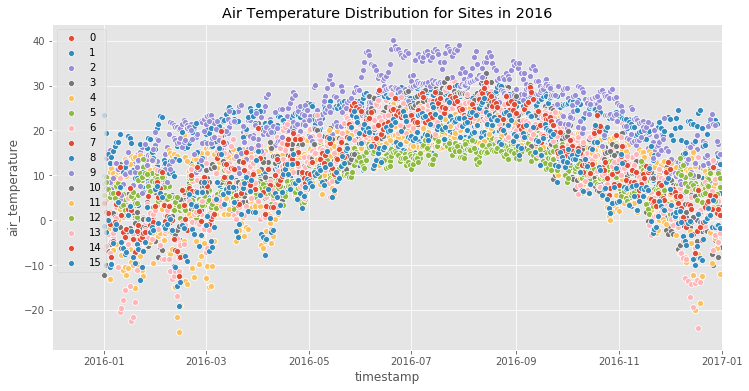

In [22]:
_ = weather.set_index('timestamp').groupby('site_id').resample('D').mean()

plt.figure(figsize=(12, 6))
plt.title('Air Temperature Distribution for Sites in 2016')
sns.set_palette(palette='RdYlGn', n_colors=16)
plt.ylabel('Degree Celsius')

for i in range(16):
  sns.scatterplot(_.loc[i].index,_.loc[i].air_temperature, label=i)
  plt.xlim('2015-12', '2017')
  plt.legend(loc='best')

We can roughly see that Site 2 has the highest overall temperature in 2016. Site 15 and 13 have very cold winter in 2016.

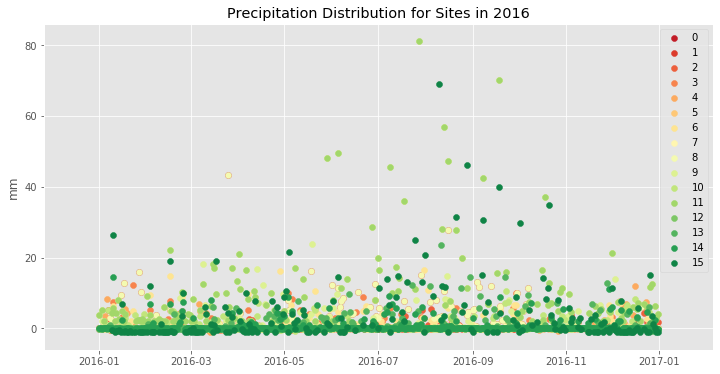

In [23]:
plt.figure(figsize=(12, 6))
sns.set_palette(palette='RdYlGn', n_colors=16)
plt.title('Precipitation Distribution for Sites in 2016')
plt.ylabel('mm')
for i in range(16):
  plt.scatter(_.loc[i].index, _.loc[i].precip_depth_1_hr, label=i)
  plt.legend()
  

We can roughly see that Site 15 has relatively more precipitation among all sites, and Site 14 seems more dry. Rain wass more frequnt June to November in 2016.

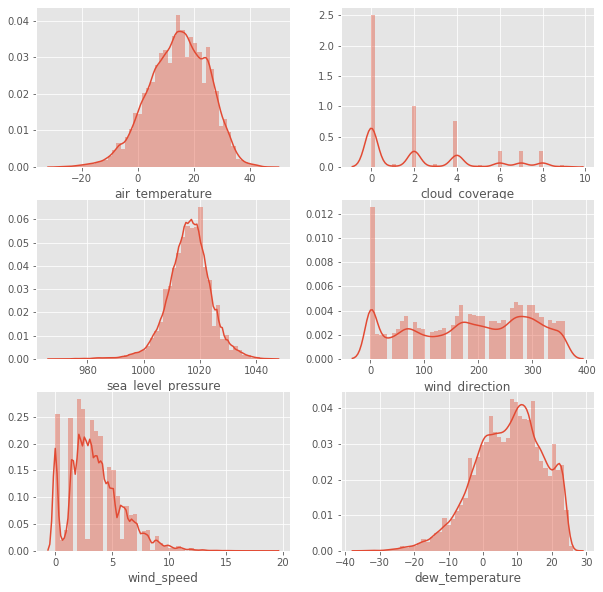

In [24]:
plt.figure(figsize=(10, 10))
plt.style.use('ggplot')
plt.subplot(3, 2, 1)
sns.distplot(weather.air_temperature)
plt.subplot(3, 2, 2)
sns.distplot(weather.cloud_coverage)
plt.subplot(3, 2, 3)
sns.distplot(weather.sea_level_pressure)
plt.subplot(3, 2, 4)
sns.distplot(weather.wind_direction)
plt.subplot(3, 2, 5)
sns.distplot(weather.wind_speed)
plt.subplot(3, 2, 6)
sns.distplot(weather.dew_temperature)
plt.show()


## Fixing wrong data




In [25]:
train_building = pd.merge(train, building, on='building_id')
train_building.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20216100 entries, 0 to 20216099
Data columns (total 9 columns):
building_id      20216100 non-null int16
meter            20216100 non-null int8
timestamp        20216100 non-null datetime64[ns]
meter_reading    20216100 non-null float32
site_id          20216100 non-null int8
primary_use      20216100 non-null object
square_feet      20216100 non-null int32
year_built       8088455 non-null float16
floor_count      3506933 non-null float16
dtypes: datetime64[ns](1), float16(2), float32(1), int16(1), int32(1), int8(2), object(1)
memory usage: 771.2+ MB


In [26]:
train_building.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,NaN
1,0,0,2016-01-01 01:00:00,0.0,0,Education,7432,2008.0,NaN
2,0,0,2016-01-01 02:00:00,0.0,0,Education,7432,2008.0,NaN
3,0,0,2016-01-01 03:00:00,0.0,0,Education,7432,2008.0,NaN
4,0,0,2016-01-01 04:00:00,0.0,0,Education,7432,2008.0,NaN


As claimed in https://www.kaggle.com/c/ashrae-energy-prediction/discussion/119261, the electric meter reading for site 0 was reproted in kBTU and needs to be converted to units of kWh through multiplying by 0.2931.

In [0]:
_ = train_building[(train_building.site_id == 0) & (train_building.meter == 0)].index

In [0]:
train_building.loc[_, 'meter_reading'] *= 0.2931

## Identifying Outliers

ref https://www.iotacommunications.com/blog/benchmarking-commercial-building-energy-use-per-square-foot/ for typical energy consumption for buildings of specific industry.

In [0]:
train_building['date'] = train_building.timestamp.dt.date
train_building['meter'] = pd.Categorical(train_building['meter']).rename_categories(
    {0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'}
)
daily = train_building[['date', 'building_id', 'meter', 'meter_reading']].copy()

In [30]:
daily = daily.groupby(['date', 'building_id', 'meter']).sum()
daily

meter_reading
date       building_id meter                      
2016-01-01 0           electricity        0.000000
                       chilledwater            NaN
                       steam                   NaN
                       hotwater                NaN
           1           electricity        0.000000
...                                            ...
2016-12-31 1447        hotwater                NaN
           1448        electricity       79.974998
                       chilledwater            NaN
                       steam                   NaN
                       hotwater                NaN

[2121336 rows x 1 columns]

In [0]:
daily_agg = daily.groupby(['date', 'meter']).agg(
    ['sum', 'mean', 'max', 'idxmax'])

In [0]:
daily_agg = daily_agg.reset_index()

In [33]:
level0 = daily_agg.columns.droplevel(0)
level1 = daily_agg.columns.droplevel(1)
level0 = ['' if x == '' else '-' + x for x in level0]
daily_agg.columns = level1 + level0
daily_agg.rename_axis(None, axis=1)
daily_agg.head()

,date,meter,meter_reading-sum,meter_reading-mean,meter_reading-max,meter_reading-idxmax
0,2016-01-01,electricity,4.218148e+06,3036.823975,1.160372e+05,"(2016-01-01, 803, electricity)"
1,2016-01-01,chilledwater,1.412169e+06,3090.084961,1.042116e+05,"(2016-01-01, 1289, chilledwater)"
2,2016-01-01,steam,6.873201e+07,218891.734375,5.095080e+07,"(2016-01-01, 1099, steam)"
3,2016-01-01,hotwater,1.609989e+06,11180.481445,2.198245e+05,"(2016-01-01, 1331, hotwater)"
4,2016-01-02,electricity,4.286619e+06,3083.898438,1.157768e+05,"(2016-01-02, 803, electricity)"


Text(0.5, 1.0, 'Total kWh per energy aspect')

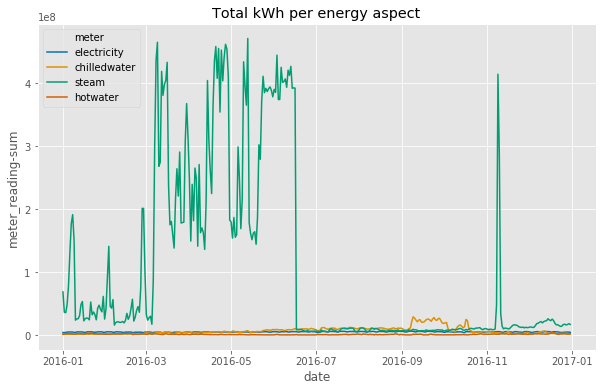

In [34]:
plt.figure(figsize=(10,6))

sns.lineplot(x='date', y='meter_reading-sum', hue='meter', 
             data=daily_agg, palette='colorblind')
plt.title('Total kWh per energy aspect')

There are some extreme values for total consumed energy, especially for steam meter.

Text(0.5, 1.0, 'Maximum kWh per energy aspect')

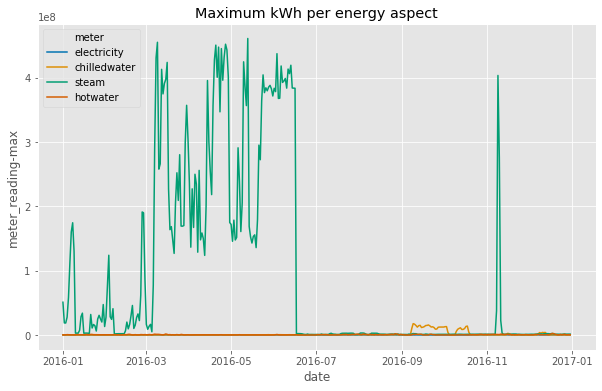

In [35]:
plt.figure(figsize=(10,6))
sns.lineplot(x='date', y='meter_reading-max', hue='meter', 
                data=daily_agg, palette='colorblind')
plt.title('Maximum kWh per energy aspect')

Comparing the sum and the max, it seems that the extreme values in sum are caused by only the max, meaning that only one building (for each day and each energy aspect) caused the extreme peaks. 



In [36]:
daily_agg['building_id_max'] = [x[1] for x in daily_agg['meter_reading-idxmax']]
daily_agg.head()

,date,meter,meter_reading-sum,meter_reading-mean,meter_reading-max,meter_reading-idxmax,building_id_max
0,2016-01-01,electricity,4.218148e+06,3036.823975,1.160372e+05,"(2016-01-01, 803, electricity)",803
1,2016-01-01,chilledwater,1.412169e+06,3090.084961,1.042116e+05,"(2016-01-01, 1289, chilledwater)",1289
2,2016-01-01,steam,6.873201e+07,218891.734375,5.095080e+07,"(2016-01-01, 1099, steam)",1099
3,2016-01-01,hotwater,1.609989e+06,11180.481445,2.198245e+05,"(2016-01-01, 1331, hotwater)",1331
4,2016-01-02,electricity,4.286619e+06,3083.898438,1.157768e+05,"(2016-01-02, 803, electricity)",803


### Electricity

In [37]:
print('Number of days that a building has the maximum electricity \
consumption of all the buildings:\n')
print(daily_agg[daily_agg['meter'] == 'electricity']
      ['building_id_max'].value_counts())

Number of days that a building has the maximum electricity consumption of all the buildings:

803     192
801      65
799      58
1088     49
993       1
794       1
Name: building_id_max, dtype: int64


The max values of electricity are caused by only 6 buildings.

In [38]:
daily_electricity = daily_agg[daily_agg.meter == 'electricity'].copy()
daily_electricity['building_id_max'] = pd.Categorical(daily_electricity.building_id_max)
daily_electricity.head()

,date,meter,meter_reading-sum,meter_reading-mean,meter_reading-max,meter_reading-idxmax,building_id_max
0,2016-01-01,electricity,4218148.5,3036.823975,116037.179688,"(2016-01-01, 803, electricity)",803
4,2016-01-02,electricity,4286619.0,3083.898438,115776.750000,"(2016-01-02, 803, electricity)",803
8,2016-01-03,electricity,4242851.5,3052.410889,115708.132812,"(2016-01-03, 803, electricity)",803
12,2016-01-04,electricity,5003739.0,3599.812256,124764.109375,"(2016-01-04, 803, electricity)",803
16,2016-01-05,electricity,5094110.0,3667.465820,125209.890625,"(2016-01-05, 803, electricity)",803


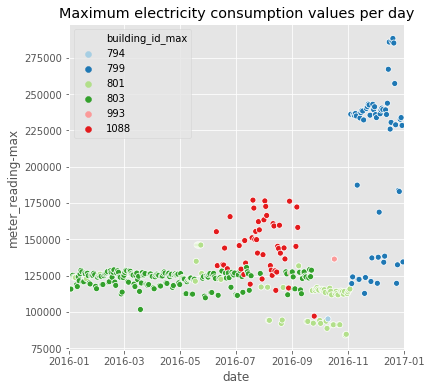

In [39]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x='date', y='meter_reading-max', data=daily_electricity, 
                hue='building_id_max', palette='Paired')
plt.title('Maximum electricity consumption values per day')
plt.xlim('2016', '2017')
plt.show()

In [0]:
daily = daily.reset_index()

Text(0.5, 1.0, 'Building 803 Meter Reading')

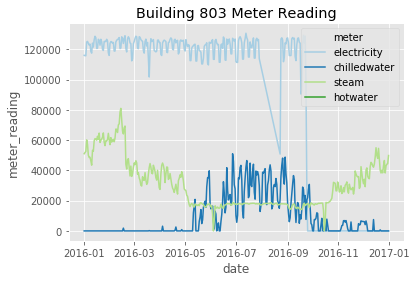

In [41]:
sns.lineplot(x='date', y='meter_reading', hue='meter', 
             data=daily[daily.building_id == 803], 
             palette='Paired') 
plt.legend(loc='upper right')
plt.title('Building 803 Meter Reading')

In [42]:
building[building.building_id == 803]

,site_id,building_id,primary_use,square_feet,year_built,floor_count
803,7,803,Education,182986,1962.0,3.0


In [43]:
print('Tota electricty consumed by Building 803 in 2016 in kWh is:')
daily[(daily.building_id == 803) & 
               (daily.meter == 'electricity')].meter_reading.sum()

Tota electricty consumed by Building 803 in 2016 in kWh is:


29591936.0

This is a building used for education and should not have such high industrial electricity consumption.

The electricty consumption dropped in late August and went back again, and then dropped to even lower in late September, which is very abnormal. The total electricity consumption in 2016 is about 30,000,000kWh and the building size is approximately 190,000 ft². This is 160 kWh/ft²/year approximately. The typical consumptions is about 20 kWh/ft²/year.

This building has a 8 fold more electricity consumption than the typical one. Maybe the meter or the software that reads it is not configured correctly.

It seems when the steam energy consumption drops from May to October, the chilledwater consumption increases.

Text(0.5, 1.0, 'Building 801 Meter Reading')

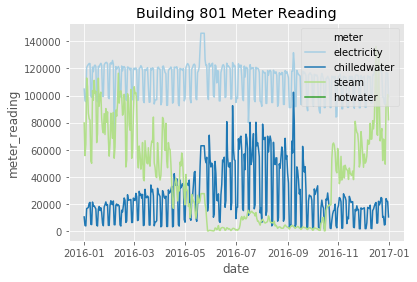

In [44]:
sns.lineplot(x='date', y='meter_reading', hue='meter', 
             data=daily[daily.building_id == 801], 
             palette='Paired') 
plt.legend(loc='upper right')
plt.title('Building 801 Meter Reading')

In [45]:
building[building.building_id == 801]

,site_id,building_id,primary_use,square_feet,year_built,floor_count
801,7,801,Education,484376,1952.0,5.0


In [46]:
print('Tota electricty consumed by Building 801 in 2016 in kWh is:')
daily[(daily.building_id == 801) & (daily.meter == 'electricity')].meter_reading.sum()

Tota electricty consumed by Building 801 in 2016 in kWh is:


40833130.0

This is a building typified as an educational center. Therefore, there should not be an industrial electricity consumption.

The electricity consumption has an average of about 110 000 kWh for 500 000 ft² each day. This 80 kWh/ft²/year. The typical consumptions is about 20 kWh/ft²/year.

This building has a 4 fold more electricity consumption than the typical one. The building shows obvious weekly pattern but no seasonal pattern in electricity consumption. Maybe the meter or the software that reads it is not configured correctly.

Text(0.5, 1.0, 'Building 799 Meter Readning')

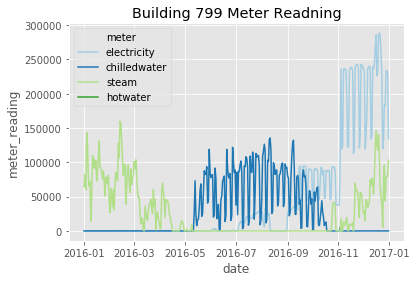

In [47]:
sns.lineplot(x='date', y='meter_reading', hue='meter', 
             data=daily[daily.building_id == 799], 
             palette='Paired') 
plt.legend(loc='upper left')
plt.title('Building 799 Meter Readning')

In [48]:
building[building.building_id == 799]

,site_id,building_id,primary_use,square_feet,year_built,floor_count
799,7,799,Education,527431,1976.0,26.0


Buidling 799, around 530000 ft², has really high electricity consumption from 2016-9 to 2016-11 with an average of 75000kWh daily, and even hier electricity consumption from 2016-11 to the end of the year with an average of 200000kWh daily.

Both consumptions are from 3 to 7 times the typical, which is about about 20 kWh/ft²/year.

Maybe the meter or the software that reads it is not configured correctly.

Text(0.5, 1.0, 'Building 1088 Meter Reading')

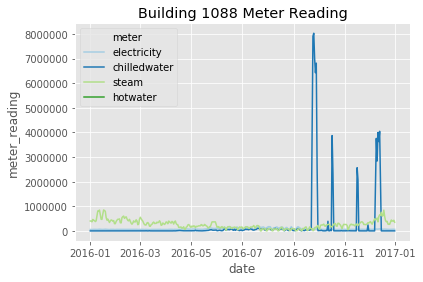

In [49]:
sns.lineplot(x='date', y='meter_reading', hue='meter', 
             data=daily[daily.building_id == 1088], 
             palette='Paired') 
plt.legend(loc='upper left')
plt.title('Building 1088 Meter Reading')

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Building 1088 Electricity Meter Reading')

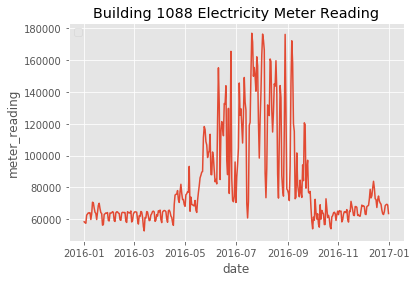

In [50]:
sns.lineplot(x='date', y='meter_reading',
             data=daily[(daily.building_id == 1088) & (daily.meter == 'electricity')], 
             palette='Paired') 
plt.legend(loc='upper left')
plt.title('Building 1088 Electricity Meter Reading')

In [51]:
building[building.building_id == 1088]

,site_id,building_id,primary_use,square_feet,year_built,floor_count
1088,13,1088,Education,287594,NaN,NaN


In [52]:
print('Tota electricty consumed by Building 1088 in 2016 in kWh is:')
daily[(daily.building_id == 1088) & (daily.meter == 'electricity')].meter_reading.sum()

Tota electricty consumed by Building 1088 in 2016 in kWh is:


30082860.0

Building 1088, around 300000ft², consumes 30000000kWh in 2016, meaning 100kWh/ft²/year was used averagely, which is 5 times higher than typical. The electricity consumption has weekly pattern in general, and from May to October electricity consumption was noisy. This could be caused by that the meter measuring AC usage is not configured correctly.

Text(0.5, 1.0, 'Building 993 Meter Reading')

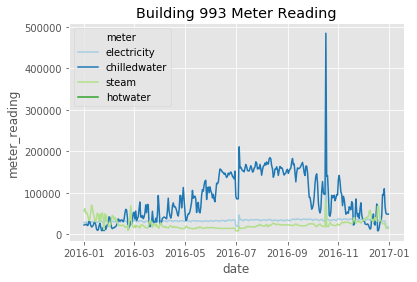

In [53]:
sns.lineplot(x='date', y='meter_reading', hue='meter', 
             data=daily[daily.building_id == 993], 
             palette='Paired') 
plt.legend(loc='upper left')
plt.title('Building 993 Meter Reading')

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Building 993 Electricity Meter Reading')

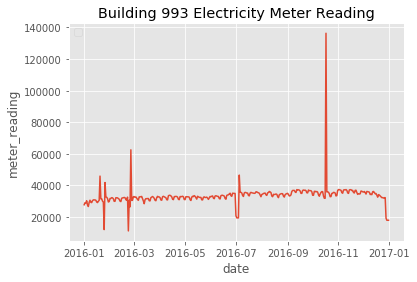

In [54]:
sns.lineplot(x='date', y='meter_reading',
             data=daily[(daily.building_id == 993) & 
                        (daily.meter == 'electricity')], 
             palette='Paired') 
plt.legend(loc='upper left')
plt.title('Building 993 Electricity Meter Reading')

In [55]:
building[building.building_id == 993]

,site_id,building_id,primary_use,square_feet,year_built,floor_count
993,9,993,Education,428647,NaN,NaN


In [56]:
print('Tota electricty consumed by Building 993 in 2016 in kWh is:')
daily[(daily.building_id == 993) & (daily.meter == 'electricity')].meter_reading.sum()

Tota electricty consumed by Building 993 in 2016 in kWh is:


12281257.0

This education center consumed around 30kWh/ft²/year in 2016, which is reasonable. 

It shows abnormal peaks in July, October and Feburary for electricity meter, and the same abnormal patterns were seen for other types of meter, which could be caused by the start of new semesters. It also has some vacational pauses in July and December.

Text(0.5, 1.0, 'Building 794 Meter Reading')

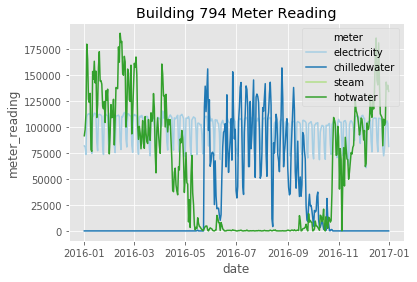

In [57]:
sns.lineplot(x='date', y='meter_reading', hue='meter', 
             data=daily[daily.building_id == 794], 
             palette='Paired') 
plt.legend(loc='upper right')
plt.title('Building 794 Meter Reading')

In [58]:
building[building.building_id == 794]

,site_id,building_id,primary_use,square_feet,year_built,floor_count
794,7,794,Education,731945,1969.0,11.0


In [59]:
print('Tota electricty consumed by Building 794 in 2016 in kWh is:')
daily[(daily.building_id == 794) & (daily.meter == 'electricity')].meter_reading.sum()

Tota electricty consumed by Building 794 in 2016 in kWh is:


36225990.0

This building has a very steady daily consumption with a weekly pattern, and without a seasonal pattern. It consumes 50 kWh/ft²/year, which is about twice the typical consumption. This piece of data seems reasonable.

### Steam

In [60]:
print('Number of days that a building has the maximum steam \
consumption of all the buildings:\n')
print(daily_agg[daily_agg['meter'] == 'steam']
      ['building_id_max'].value_counts())

Number of days that a building has the maximum steam consumption of all the buildings:

1099    158
1197    101
1168    100
1148      7
Name: building_id_max, dtype: int64


In [61]:
daily_steam = daily_agg[daily_agg.meter == 'steam'].copy()
daily_steam['building_id_max'] = pd.Categorical(daily_steam.building_id_max)
daily_steam.head()

,date,meter,meter_reading-sum,meter_reading-mean,meter_reading-max,meter_reading-idxmax,building_id_max
2,2016-01-01,steam,68732008.0,218891.734375,50950800.0,"(2016-01-01, 1099, steam)",1099
6,2016-01-02,steam,36615048.0,116608.429688,18746688.0,"(2016-01-02, 1099, steam)",1099
10,2016-01-03,steam,35656632.0,113556.148438,18646320.0,"(2016-01-03, 1099, steam)",1099
14,2016-01-04,steam,48600056.0,154777.250000,27760238.0,"(2016-01-04, 1099, steam)",1099
18,2016-01-05,steam,78548728.0,250155.187500,58403172.0,"(2016-01-05, 1099, steam)",1099


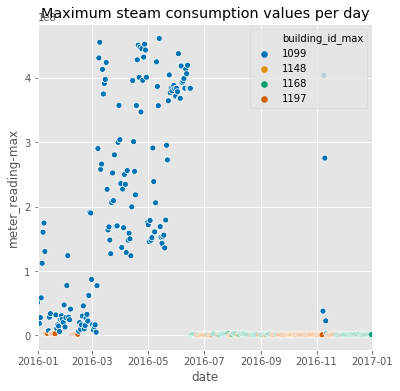

In [62]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x='date', y='meter_reading-max', data=daily_steam, 
                hue='building_id_max', palette='colorblind')
plt.title('Maximum steam consumption values per day')
plt.xlim('2016', '2017')
plt.show()

Text(0.5, 1.0, 'Building 1099 Meter Reading')

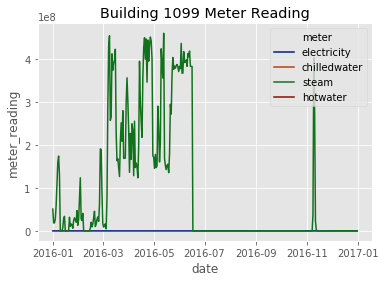

In [63]:
sns.lineplot(x='date', y='meter_reading', hue='meter', 
             data=daily[daily.building_id == 1099], 
             palette='dark') 
plt.legend(loc='upper right')
plt.title('Building 1099 Meter Reading')

In [64]:
building[building.building_id == 1099]

,site_id,building_id,primary_use,square_feet,year_built,floor_count
1099,13,1099,Education,332884,NaN,NaN


In [65]:
print('Tota steam consumed by Building 1099 in 2016 in kWh is:')
train_building[(train_building.building_id == 1099) & 
               (train_building.meter == 'steam')].meter_reading.sum()

Tota steam consumed by Building 1099 in 2016 in kWh is:


33501140000.0

Building 1099 have really large steam consumption from January to June and in November. There was no obvious pattern and the data was noisy. This piece of data seems wrong.

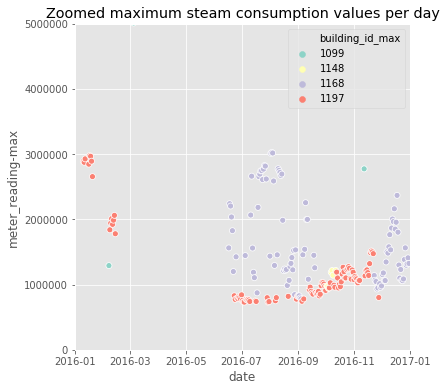

In [66]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x='date', y='meter_reading-max', data=daily_steam, 
                hue='building_id_max', palette='Set3')
plt.title('Zoomed maximum steam consumption values per day')
plt.xlim('2016', '2017')
plt.ylim(0, 5e6)
plt.show()

Max steam consumption plot was zoomed in to see status of buildings other than Building 1099. It seems that Building 1197 has some extreme highs in January and February, and Building 1168 has some extreme high consumption from July to September, and in December. 

Text(0.5, 1.0, 'Building 1197 Meter Reading')

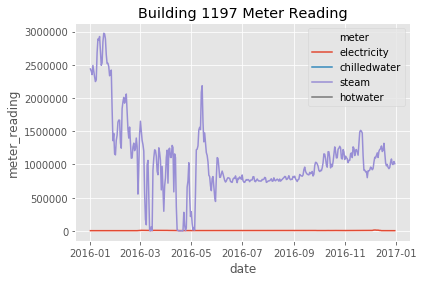

In [67]:
sns.lineplot(x='date', y='meter_reading', hue='meter',
             data=daily[daily.building_id == 1197])
plt.legend()
plt.title('Building 1197 Meter Reading')

In [68]:
print('Tota steam consumed by Building 1197 in 2016 in kWh is:')
daily[(daily.meter == 'steam') & 
      (daily.building_id == 1197)].meter_reading.sum()

Tota steam consumed by Building 1197 in 2016 in kWh is:


388395040.0

In [69]:
building[building.building_id == 1197]

,site_id,building_id,primary_use,square_feet,year_built,floor_count
1197,13,1197,Services,50552,NaN,NaN


Building 1197 has some weekly pattern from June to September, but for the other dates the consumption pattern is very noisy. 8000kWh/ft²/year of steam energy was consumed for this building in 2016, which seems incorrect, and steam should not have been used this much in summer for heating and hot water. 

Text(0.5, 1.0, 'Building 1168 Meter Reading')

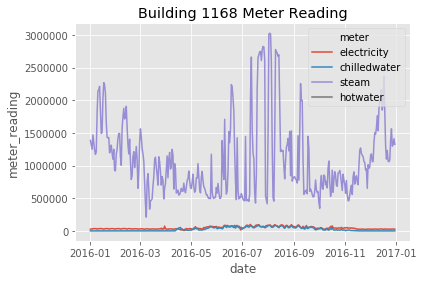

In [70]:
sns.lineplot(x='date', y='meter_reading', hue='meter',
             data=daily[daily.building_id == 1168])
plt.legend()
plt.title('Building 1168 Meter Reading')

In [71]:
building[building.building_id == 1168]

,site_id,building_id,primary_use,square_feet,year_built,floor_count
1168,13,1168,Office,577101,NaN,NaN


In [72]:
print('Tota steam consumed by Building 1168 in 2016 in kWh is:')
daily[(daily.meter == 'steam') & 
      (daily.building_id == 1168)].meter_reading.sum()

Tota steam consumed by Building 1168 in 2016 in kWh is:


402418880.0

A 1 000 000 kWh daily average is too big up to a 500 000 ft² office.

Text(0.5, 1.0, 'Building 1148 Meter Reading')

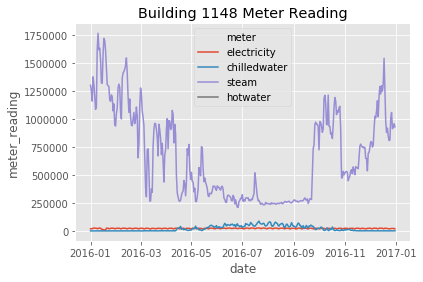

In [73]:
sns.lineplot(x='date', y='meter_reading', hue='meter',
             data=daily[daily.building_id == 1148])
plt.legend()
plt.title('Building 1148 Meter Reading')

In [74]:
building[building.building_id == 1148]

,site_id,building_id,primary_use,square_feet,year_built,floor_count
1148,13,1148,Office,861524,NaN,NaN


In [75]:
print('Tota steam consumed by Building 1148 in 2016 in kWh is:')
daily[(daily.meter == 'steam') & 
      (daily.building_id == 1148)].meter_reading.sum()

Tota steam consumed by Building 1148 in 2016 in kWh is:


247407550.0

Steam energy of approximately 280kWh/ft²/year was consumed in 2016, which is pretty high for office buildings.

### Chilledwater

In [76]:
daily_chilledwater = daily_agg[daily_agg.meter == 'chilledwater'].copy()
print('Number of days that a building has the maximum steam \
consumption of all the buildings:\n')
daily_chilledwater.building_id_max.value_counts()

Number of days that a building has the maximum steam consumption of all the buildings:



1284    134
76       92
1258     41
1289     38
778      37
1088     10
29       10
1156      2
60        1
50        1
Name: building_id_max, dtype: int64

In [0]:
daily_chilledwater['building_id_max'] = pd.Categorical(
    daily_chilledwater['building_id_max'])

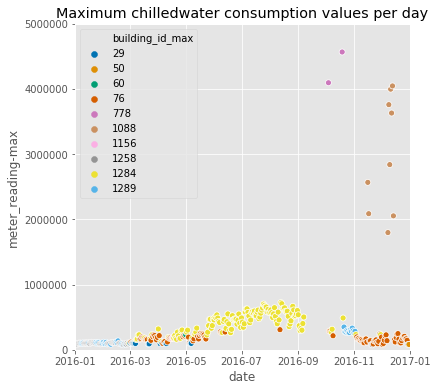

In [78]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x='date', y='meter_reading-max', data=daily_chilledwater, 
                hue='building_id_max', palette='colorblind')
plt.title('Maximum chilledwater consumption values per day')
plt.xlim('2016', '2017')
plt.ylim(0, 5e6)
plt.show()

From the scatterplot above, we can see that Building 778 and Building 1088 have some abnormal high chilledwater consumption.

Text(0.5, 1.0, 'Building 1088 Meter Reading')

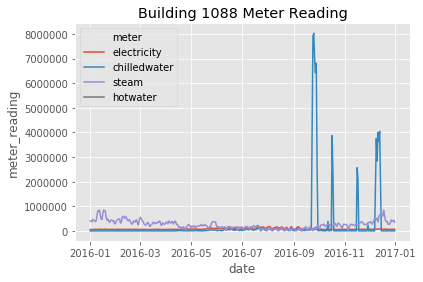

In [79]:
sns.lineplot(x='date', y='meter_reading', hue='meter',
             data=daily[daily.building_id == 1088])
plt.legend()
plt.title('Building 1088 Meter Reading')

In [80]:
building[building.building_id == 1088]

,site_id,building_id,primary_use,square_feet,year_built,floor_count
1088,13,1088,Education,287594,NaN,NaN


In [81]:
print('Tota chilledwater consumed by Building 1088 in 2016 in kWh is:')
daily[(daily.building_id == 1088) & 
      (daily.meter == 'chilledwater')].meter_reading.sum()

Tota chilledwater consumed by Building 1088 in 2016 in kWh is:


83697950.0

This building has a typical hot part of the year chilledwater consumption, with a maximum of 100 000 kWh. In some other short periods has very high peaks of about a hundred times more, which is very abnormal.


Tota chilledwater consumed by Building 1088 in 2016 in kWh is:
438287170.0


,site_id,building_id,primary_use,square_feet,year_built,floor_count
778,6,778,Entertainment/public assembly,108339,NaN,NaN


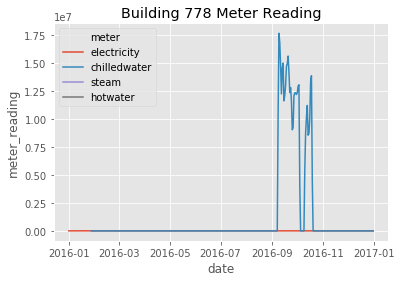

In [82]:
sns.lineplot(x='date', y='meter_reading', hue='meter',
             data=daily[daily.building_id == 778])
plt.legend()
plt.title('Building 778 Meter Reading')

print('Tota chilledwater consumed by Building 1088 in 2016 in kWh is:')
print(daily[(daily.building_id == 778) & 
      (daily.meter == 'chilledwater')].meter_reading.sum())
building[building.building_id == 778]

Text(0.5, 1.0, 'Zoomed Building 778 Meter Reading')

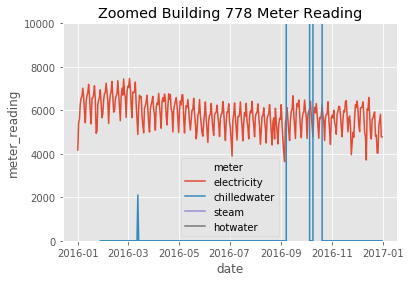

In [83]:
sns.lineplot(x='date', y='meter_reading', hue='meter',
             data=daily[daily.building_id == 778])
plt.legend()
plt.ylim(0, 1e4)
plt.title('Zoomed Building 778 Meter Reading')

The consumption of this building is really high only for a span of two months, and the rest of the time almost no chilledwater was consumed. 

Probably, the measure is wrong.

### hotwater

In [84]:
daily_hotwater = daily_agg[daily_agg.meter == 'hotwater'].copy()
print('Number of days that a building has the maximum hotwater \
consumption of all the buildings:\n')
daily_chilledwater.building_id_max.value_counts()

Number of days that a building has the maximum hotwater consumption of all the buildings:



1284    134
76       92
1258     41
1289     38
778      37
1088     10
29       10
1156      2
60        1
50        1
Name: building_id_max, dtype: int64

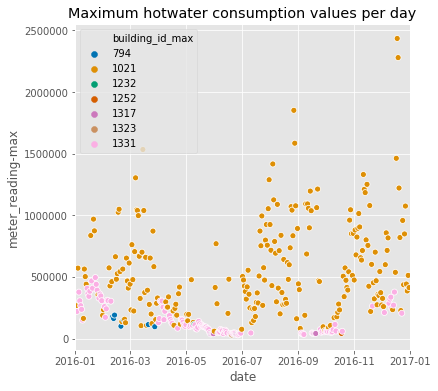

In [85]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x='date', y='meter_reading-max', data=daily_hotwater, 
                hue='building_id_max', palette='colorblind')
plt.title('Maximum hotwater consumption values per day')
plt.xlim('2016', '2017')
plt.show()

From the scatterplot above, we can see that Building 1021 and building 1331 have aberant hotwater use.

Tota chilledwater consumed by Building 1021 in 2016 in kWh is:
140482340.0


,site_id,building_id,primary_use,square_feet,year_built,floor_count
1021,10,1021,Entertainment/public assembly,213762,NaN,2.0


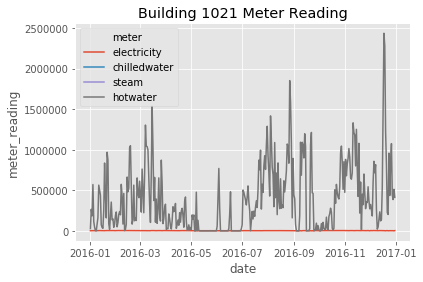

In [86]:
sns.lineplot(x='date', y='meter_reading', hue='meter',
             data=daily[daily.building_id == 1021])
plt.legend()
plt.title('Building 1021 Meter Reading')

print('Tota chilledwater consumed by Building 1021 in 2016 in kWh is:')
print(daily[(daily.building_id == 1021) & 
      (daily.meter == 'hotwater')].meter_reading.sum())
building[building.building_id == 1021]

This consumption is very big for entertainment/public assembly building.



Tota chilledwater consumed by Building 131 in 2016 in kWh is:
40476776.0


,site_id,building_id,primary_use,square_feet,year_built,floor_count
1331,15,1331,Education,171008,1930.0,NaN


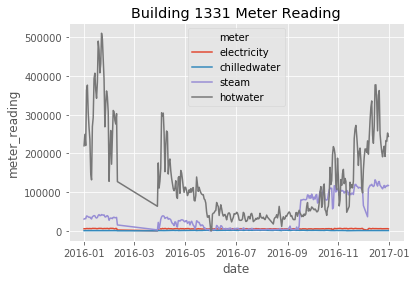

In [87]:
sns.lineplot(x='date', y='meter_reading', hue='meter',
             data=daily[daily.building_id == 1331])
plt.legend()
plt.title('Building 1331 Meter Reading')

print('Tota chilledwater consumed by Building 131 in 2016 in kWh is:')
print(daily[(daily.building_id == 1331) & 
      (daily.meter == 'hotwater')].meter_reading.sum())
building[building.building_id == 1331]

Text(0.5, 1.0, 'Zoomed Building 1331 Meter Reading')

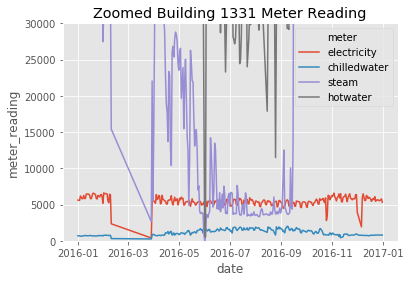

In [88]:
sns.lineplot(x='date', y='meter_reading', hue='meter',
             data=daily[daily.building_id == 1331])
plt.legend()
plt.ylim(0, 30000)
plt.title('Zoomed Building 1331 Meter Reading')

The data between Febuary 10th and March 29th are missing for four types of meters. Approximately 240kWh/ft²/year of hotwater energy was used for this education center in 2016, which is a very consumption for an education building.

### Conclusions on outliers 

Taking only the buildings that consume maxium energy per day per type, we can see that there are a lot of measure scale errors.

The error could be:

*   The meter is not configured correctly. 
*   The software has not the units configured correctly. 
*   The software has not the decimal digits configured correctly.

Some changes over time irregularly, indicating that some buildings have more than one meter. One error in one meter and the overall measure is unreliable.

This notebook has only identified outliers that influence the maximum consumption in a daily basis. This is only the tip of the iceberg. A sound analysis should be done to detect and correct these outliers.

# Data Wrangling

## Handling Outliers

Energy consumption outliers per energy aspect:  

*   electricity- Building 803, 801, 799, 1088
*   steam- Building 1099, 1197, 1168, 1148
*   chilledwater- Building 1088, 778
*   hotwater- Building 1021, 1331



In [89]:
train_building.shape

(20216100, 10)

In [90]:
electricity = train_building[(train_building.meter == 'electricity') & 
      ~(train_building.building_id.isin([803, 801, 799, 1088]))].copy()
electricity.shape

(12026390, 10)

In [91]:
electricity.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12026390 entries, 0 to 20216099
Data columns (total 10 columns):
building_id      12026390 non-null int16
meter            12026390 non-null category
timestamp        12026390 non-null datetime64[ns]
meter_reading    12026390 non-null float32
site_id          12026390 non-null int8
primary_use      12026390 non-null object
square_feet      12026390 non-null int32
year_built       5565124 non-null float16
floor_count      2939076 non-null float16
date             12026390 non-null object
dtypes: category(1), datetime64[ns](1), float16(2), float32(1), int16(1), int32(1), int8(1), object(2)
memory usage: 550.5+ MB


In [92]:
steam = train_building[(train_building.meter == 'steam') &
              ~(train_building.building_id.isin([1099, 1197, 1168, 1148]))].copy()
steam.shape        

(2673577, 10)

In [93]:
steam.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2673577 entries, 7977132 to 20215620
Data columns (total 10 columns):
building_id      2673577 non-null int16
meter            2673577 non-null category
timestamp        2673577 non-null datetime64[ns]
meter_reading    2673577 non-null float32
site_id          2673577 non-null int8
primary_use      2673577 non-null object
square_feet      2673577 non-null int32
year_built       567697 non-null float16
floor_count      104597 non-null float16
date             2673577 non-null object
dtypes: category(1), datetime64[ns](1), float16(2), float32(1), int16(1), int32(1), int8(1), object(2)
memory usage: 122.4+ MB


In [94]:
chilledwater = train_building[(train_building.meter == 'chilledwater') &
              ~(train_building.building_id.isin([1088, 778]))].copy()
chilledwater.shape

(4165572, 10)

In [95]:
chilledwater.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4165572 entries, 62914 to 20153872
Data columns (total 10 columns):
building_id      4165572 non-null int16
meter            4165572 non-null category
timestamp        4165572 non-null datetime64[ns]
meter_reading    4165572 non-null float32
site_id          4165572 non-null int8
primary_use      4165572 non-null object
square_feet      4165572 non-null int32
year_built       1362881 non-null float16
floor_count      209891 non-null float16
date             4165572 non-null object
dtypes: category(1), datetime64[ns](1), float16(2), float32(1), int16(1), int32(1), int8(1), object(2)
memory usage: 190.7+ MB


In [96]:
hotwater = train_building[(train_building.meter == 'hotwater') &
              ~(train_building.building_id.isin([1021, 1331]))].copy()
hotwater.shape

(1247930, 10)

In [97]:
hotwater.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1247930 entries, 1066996 to 20123407
Data columns (total 10 columns):
building_id      1247930 non-null int16
meter            1247930 non-null category
timestamp        1247930 non-null datetime64[ns]
meter_reading    1247930 non-null float32
site_id          1247930 non-null int8
primary_use      1247930 non-null object
square_feet      1247930 non-null int32
year_built       559670 non-null float16
floor_count      218843 non-null float16
date             1247930 non-null object
dtypes: category(1), datetime64[ns](1), float16(2), float32(1), int16(1), int32(1), int8(1), object(2)
memory usage: 57.1+ MB


In [98]:
len(electricity) + len(hotwater) + len(chilledwater) + len(steam)

20113469

The original dataset has 20216100 rows; after removing outliers, 20113469 rows are left, meaning we lost 0.5% data.

There are still lots of zero values for meter reading that need to be handled.

In [99]:
electricity

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,date
0,0,electricity,2016-01-01 00:00:00,0.000000,0,Education,7432,2008.0,NaN,2016-01-01
1,0,electricity,2016-01-01 01:00:00,0.000000,0,Education,7432,2008.0,NaN,2016-01-01
2,0,electricity,2016-01-01 02:00:00,0.000000,0,Education,7432,2008.0,NaN,2016-01-01
3,0,electricity,2016-01-01 03:00:00,0.000000,0,Education,7432,2008.0,NaN,2016-01-01
4,0,electricity,2016-01-01 04:00:00,0.000000,0,Education,7432,2008.0,NaN,2016-01-01
...,...,...,...,...,...,...,...,...,...,...
20216095,403,electricity,2016-12-31 19:00:00,43.660000,3,Education,49500,1962.0,NaN,2016-12-31
20216096,403,electricity,2016-12-31 20:00:00,43.639999,3,Education,49500,1962.0,NaN,2016-12-31
20216097,403,electricity,2016-12-31 21:00:00,43.889999,3,Education,49500,1962.0,NaN,2016-12-31
20216098,403,electricity,2016-12-31 22:00:00,44.369999,3,Education,49500,1962.0,NaN,2016-12-31


In [100]:
# create dataset without max outliers
train_rm_max = pd.concat([electricity, steam, hotwater, chilledwater])
train_rm_max.shape

(20113469, 10)

In [101]:
# check daily consumption per energy type per building after removing max outliers
daily_rm_max = train_rm_max[['date', 'building_id', 
                             'meter', 'meter_reading']].copy()
daily_rm_max = daily_rm_max.groupby(['date', 'building_id', 'meter']).sum()
daily_rm_agg = daily_rm_max.groupby(['date', 'meter']).agg(
    ['sum', 'mean', 'max', 'idxmax']).reset_index()
level0 = daily_rm_agg.columns.droplevel(0)
level1 = daily_rm_agg.columns.droplevel(1)
level0 = ['' if x == '' else '-' + x for x in level0]
daily_rm_agg.columns = level1 + level0
daily_rm_agg.rename_axis(None, axis=1)
daily_rm_agg.head()

,date,meter,meter_reading-sum,meter_reading-mean,meter_reading-max,meter_reading-idxmax
0,2016-01-01,electricity,3.938935e+06,2843.996338,81860.343750,"(2016-01-01, 794, electricity)"
1,2016-01-01,chilledwater,1.410710e+06,3093.662354,104211.648438,"(2016-01-01, 1289, chilledwater)"
2,2016-01-01,steam,1.265492e+07,40822.312500,871312.500000,"(2016-01-01, 1159, steam)"
3,2016-01-01,hotwater,1.361933e+06,9591.076172,91654.414062,"(2016-01-01, 794, hotwater)"
4,2016-01-02,electricity,4.016874e+06,2898.177002,80746.367188,"(2016-01-02, 794, electricity)"


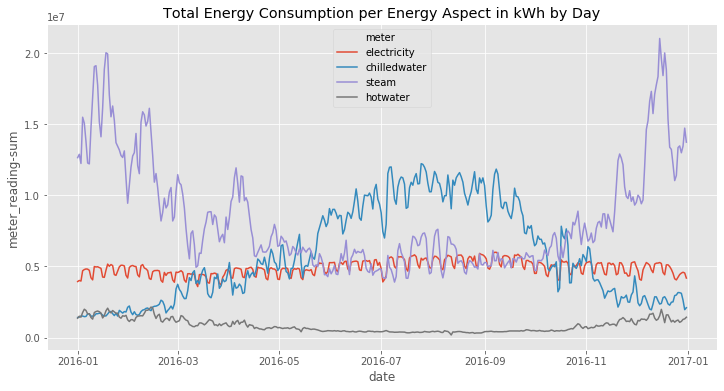

In [102]:
plt.figure(figsize=(12, 6))
plt.title('Total Energy Consumption per Energy Aspect in kWh by Day')
sns.lineplot(x='date', y='meter_reading-sum', hue='meter', data=daily_rm_agg)

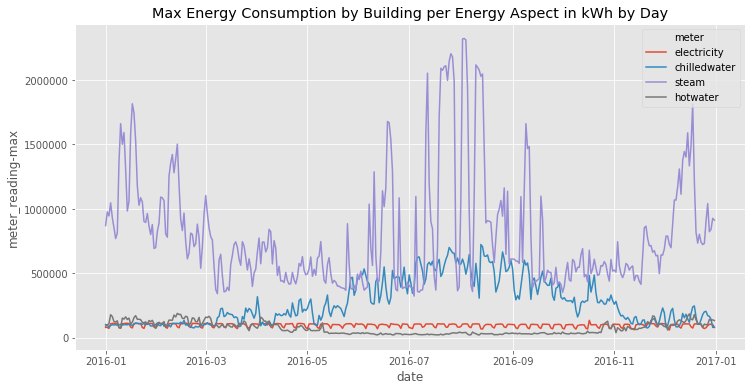

In [103]:
plt.figure(figsize=(12, 6))
plt.title('Max Energy Consumption by Building per Energy Aspect in kWh by Day')
sns.lineplot(x='date', y='meter_reading-max', hue='meter', data=daily_rm_agg)

We can see that the data is apparently improved compared to before the max outliers were removed.

## Handling Missing Values

### Missing values in train.csv

In [104]:
print('There are {} zero meter reading for electricity meter.'.format(
    len(electricity[electricity.meter_reading == 0])))
print('There are {} zero meter reading for steam meter.'.format(
    len(steam[steam.meter_reading == 0])))
print('There are {} zero meter reading for hotwater meter.'.format(
    len(hotwater[hotwater.meter_reading == 0])))
print('There are {} zero meter reading for chilledwater meter.'.format(
    len(chilledwater[chilledwater.meter_reading == 0])))

There are 523204 zero meter reading for electricity meter.
There are 346479 zero meter reading for steam meter.
There are 337198 zero meter reading for hotwater meter.
There are 649262 zero meter reading for chilledwater meter.


In [105]:
train_rm_max.meter_reading.isin([0]).sum()/train.shape[0]

0.09181508797443622

9% of the meter reading is still 0 after max outliers are removed.

### Missing values in weather.csv

In [107]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
site_id               139773 non-null int8
timestamp             139773 non-null datetime64[ns]
air_temperature       139718 non-null float16
cloud_coverage        70600 non-null float16
dew_temperature       139660 non-null float16
precip_depth_1_hr     89484 non-null float16
sea_level_pressure    129155 non-null float16
wind_direction        133505 non-null float16
wind_speed            139469 non-null float16
dtypes: datetime64[ns](1), float16(7), int8(1)
memory usage: 3.1 MB


This csv has hourly weather information for 16 sites in 2016. So this should have 140,544 records (16 x 24 x 366, 2016 is a leap year). But this csv has 139,773 records so 771 hours of data is missing.

In [0]:
import datetime
time_format = "%Y-%m-%d %H:%M:%S"
start_date = weather.timestamp.dt.date.min()
end_date = weather.timestamp.dt.date.max()
total_hours = int(((end_date - start_date).total_seconds() + 3600) / 3600)
hour_list = [np.datetime64(end_date - datetime.timedelta(hours=x)) 
for x in range(total_hours)]
missing_hours = []

In [0]:
for site_id in range(16):
    site_hours = np.array(weather[weather.site_id == site_id]['timestamp'])
    new_rows = pd.DataFrame(np.setdiff1d(hour_list, site_hours), 
                            columns=['timestamp'])
    new_rows['site_id'] = site_id
    weather = pd.concat([weather, new_rows], axis=0, sort=True)

In [177]:
weather = reduce_mem_usage(weather)
weather.info()

Mem. usage decreased to  3.07 Mb (23.3% reduction)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139800 entries, 0 to 139799
Data columns (total 9 columns):
air_temperature       139718 non-null float16
cloud_coverage        70600 non-null float16
dew_temperature       139660 non-null float16
precip_depth_1_hr     89484 non-null float16
sea_level_pressure    129155 non-null float16
site_id               139800 non-null int8
timestamp             139800 non-null datetime64[ns]
wind_direction        133505 non-null float16
wind_speed            139469 non-null float16
dtypes: datetime64[ns](1), float16(7), int8(1)
memory usage: 3.1 MB
